In [1]:
import logging
import warnings
from collections import defaultdict
from dataclasses import dataclass
from pprint import pprint

import qcportal
import openeye # these two lines prevent zstd header error

import numpy as np
from openff.qcsubmit import workflow_components
from openff.qcsubmit.factories import TorsiondriveDatasetFactory
from openff.qcsubmit.workflow_components import TorsionIndexer
from openff.toolkit import ForceField, Molecule
from openff.toolkit.utils import GLOBAL_TOOLKIT_REGISTRY, OpenEyeToolkitWrapper
from tqdm import tqdm

In [2]:
# Warnings that tell us we have undefined stereo and charged molecules
logging.getLogger("openff.toolkit").setLevel(logging.ERROR)
warnings.simplefilter("ignore")

In [3]:
# deregister openeye wrapper to use rdkit throughout
GLOBAL_TOOLKIT_REGISTRY.deregister_toolkit(OpenEyeToolkitWrapper)

In [4]:
from rdkit.Chem.Draw import MolsToGridImage, rdDepictor, rdMolDraw2D

def draw_rdkit(rdmol, matches):
    rdDepictor.SetPreferCoordGen(True)
    rdDepictor.Compute2DCoords(rdmol)
    rdmol = rdMolDraw2D.PrepareMolForDrawing(rdmol)
    mols = [rdmol for _ in matches]
    return MolsToGridImage(
        mols,
        useSVG=True,
        highlightAtomLists=matches,
        subImgSize=(300, 300),
        molsPerRow=2,
    )

In [5]:
def manual_atoms(smiles, param):
    "Convert a set of SMILES and display them to pick specific torsions"
    mols = [Molecule.from_smiles(s, allow_undefined_stereo=True) for s in smiles]
    for m in mols:
        labels = ff.label_molecules(m.to_topology())[0]["ProperTorsions"]
        atom_indices = [k for k, v in labels.items() if v.id == param]
        print(atom_indices)
        display(draw_rdkit(m.to_rdkit(), atom_indices))
    return mols

In [6]:
def add_torsion(mol, atom_indices):
    torsion_indexer = TorsionIndexer()
    torsion_indexer.add_torsion(atom_indices, (0, 3), (-165, 180))
    mol.properties["dihedrals"] = torsion_indexer

# Dataset Preparation

## Load Smiles and Force Field

In [7]:
p_smiles = defaultdict(list) # pid -> [smiles]
with open("all.smiles") as inp:
    for line in inp:
        [pid, smiles] = line.split() # lines of "pid smiles"
        p_smiles[pid].append(smiles)

print(f"loaded {sum((len(v) for v in p_smiles.values()))} smiles for {len(p_smiles)} parameters")

ff = ForceField("tm-2.2.offxml")

loaded 19 smiles for 19 parameters


## Tag the torsions to drive

### Select non-ring torsions

labeling molecules:   0%|                                                                      | 0/19 [00:00<?, ?it/s]

t138a


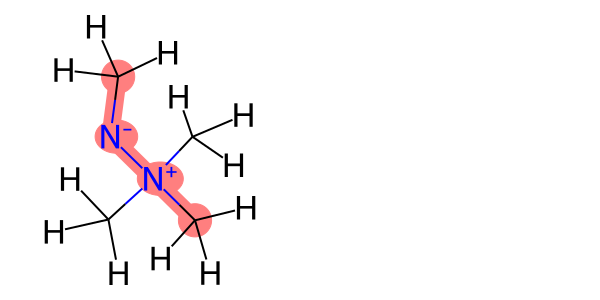

t115h


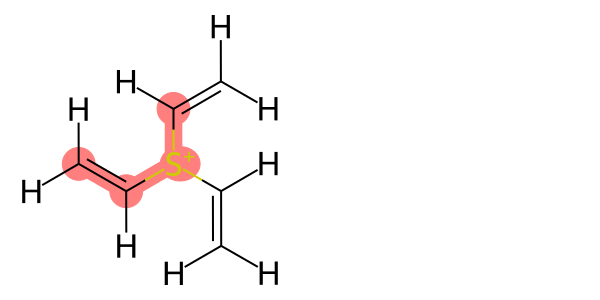

t116i


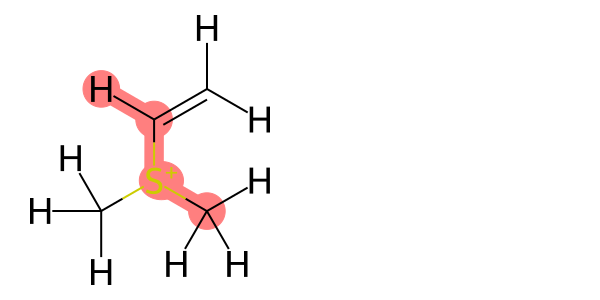

t116j


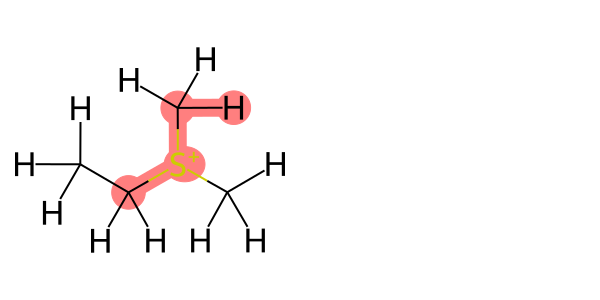

t142k


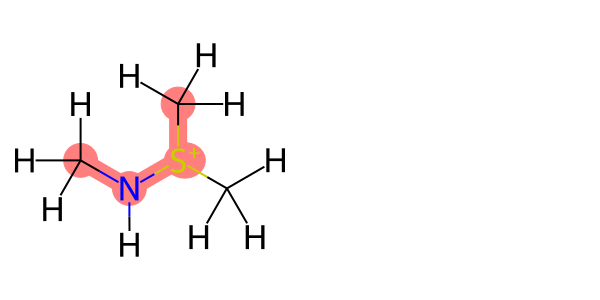

t142j


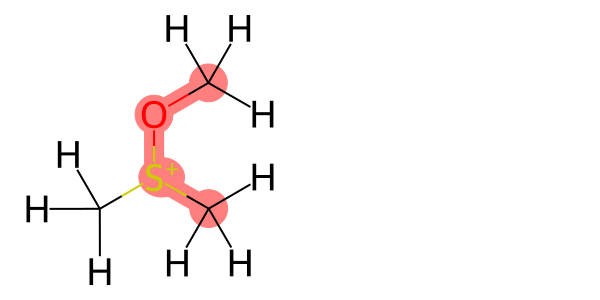

labeling molecules:  32%|███████████████████▌                                          | 6/19 [00:00<00:00, 50.78it/s]

t133g


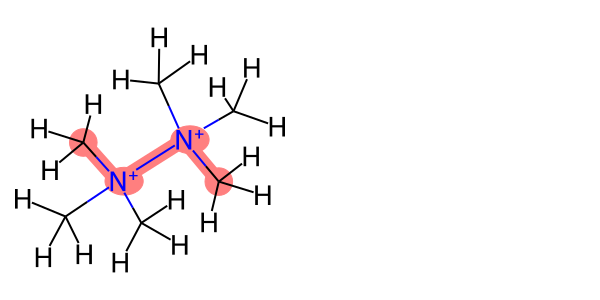

t150


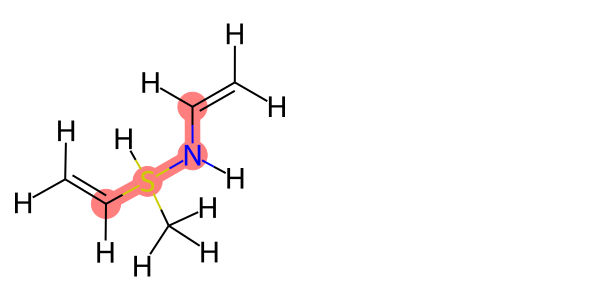

t59g


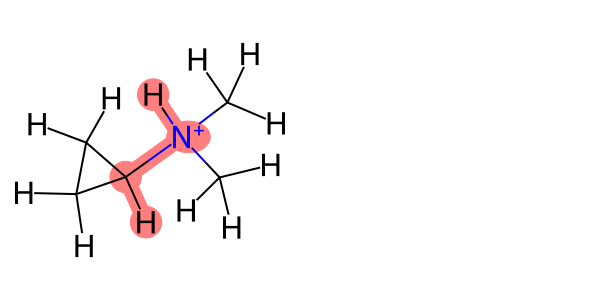

t60g


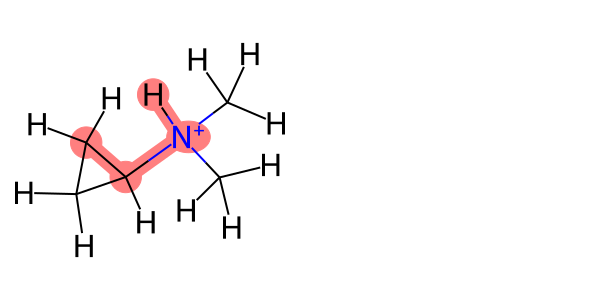

t119h


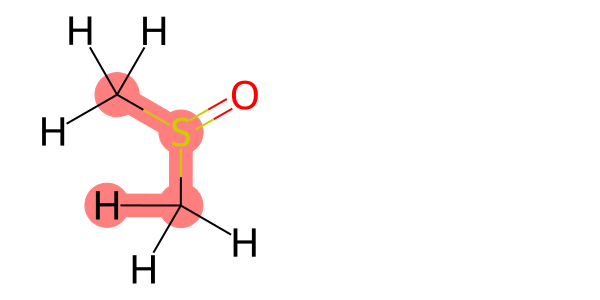

t164


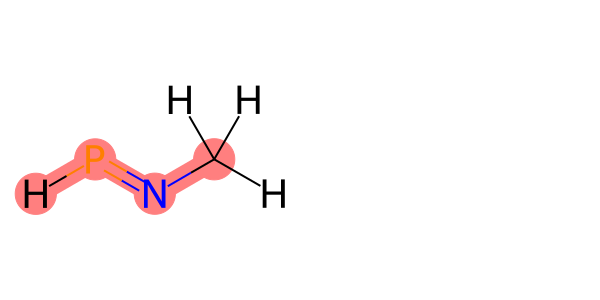

labeling molecules:  63%|██████████████████████████████████████▌                      | 12/19 [00:00<00:00, 50.73it/s]

t122h


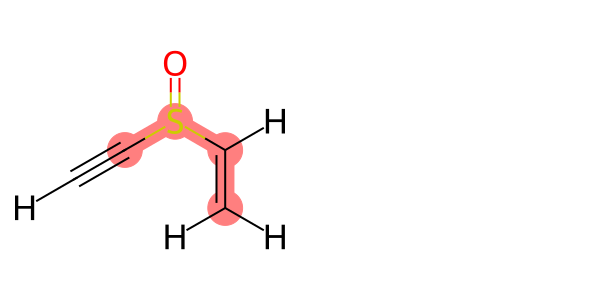

t82h


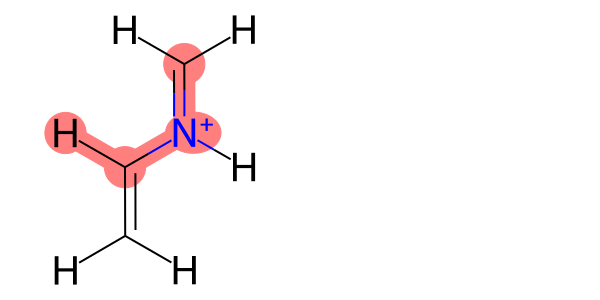

t19a


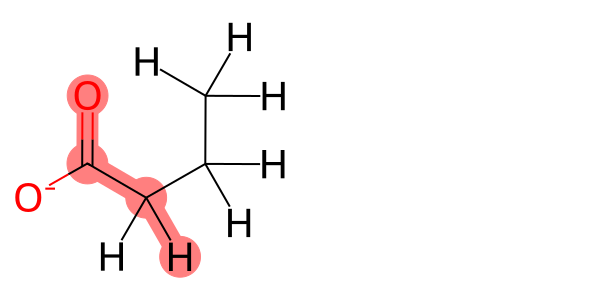

t62h


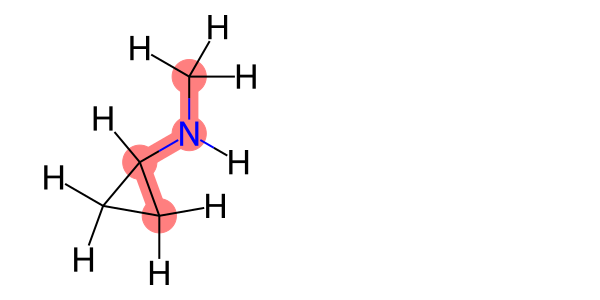

t143i


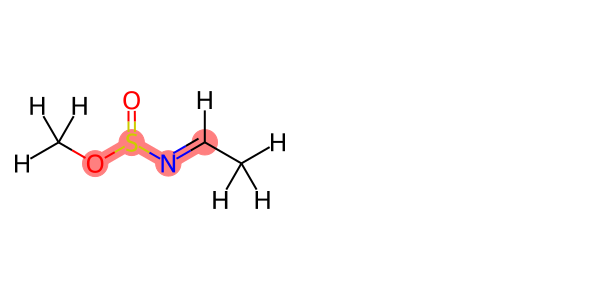

t42a


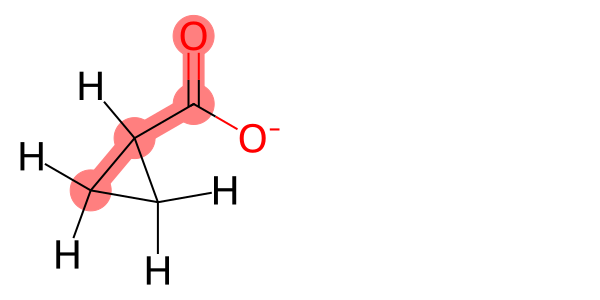

labeling molecules:  95%|█████████████████████████████████████████████████████████▊   | 18/19 [00:00<00:00, 51.76it/s]

t162


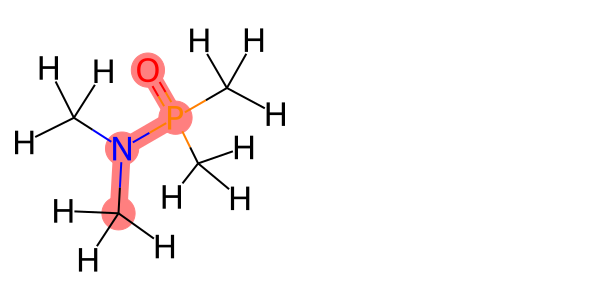

labeling molecules: 100%|█████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 51.32it/s]

tagged 19 molecules


In [8]:
molecules: list[Molecule] = []

# adapted from 2022-04-29-OpenFF-multiplicity-correction-torsion-drive-data
# in the function create_tagged_molecules

for pid, smiles in tqdm(p_smiles.items(), desc="labeling molecules"):
    for smile in smiles:
        mol = Molecule.from_smiles(smile, allow_undefined_stereo=True)
        labels = ff.label_molecules(mol.to_topology())[0]["ProperTorsions"]
        for atom_indices in (k for k, v in labels.items() if v.id == pid):
            print(pid)
            display(draw_rdkit(mol.to_rdkit(), [atom_indices]))
            torsion_indexer = TorsionIndexer()
            torsion_indexer.add_torsion(atom_indices, (0, 3), (-165, 180))
            mol.properties["dihedrals"] = torsion_indexer
            molecules.append(mol)
            break # so Pavan only takes one from each, at most
        else:
            print(f"never found a match for {pid}")

print(f"tagged {len(molecules)} molecules")

# Prepare the dataset

Again, this is adapted from [the OpenFF multiplicity correction notebook][example]

[example]: https://github.com/openforcefield/qca-dataset-submission/blob/08ace97758087f06cf22a986fc9ee838f72edae7/submissions/2022-04-29-OpenFF-multiplicity-correction-torsion-drive-data/Dataset_Generation.ipynb

In [9]:
dataset_factory = TorsiondriveDatasetFactory()
dataset_factory.add_workflow_components(workflow_components.StandardConformerGenerator(max_conformers=10))

DSNAME = "OpenFF Torsion Drive Supplement v1.0"
DSDIR  = "2024-04-17-OpenFF-Torsion-Drive-Supplement-v1.0"

dataset = dataset_factory.create_dataset(
    dataset_name=DSNAME,
    tagline=DSNAME,
    description="Additional training data for Sage 2.2.0 proper torsions and new parameters from the torsion multiplicity work",
    molecules=molecules,
)

dataset.metadata.submitter = "ntBre"
dataset.metadata.long_description_url = (
    "https://github.com/openforcefield/qca-dataset-submission/tree/master/"
    "submissions/" + DSDIR
)

StandardConformerGenerator    :   0%|                    | 0/18 [00:00<?, ?it/s][11:09:37] UFFTYPER: Unrecognized charge state for atom: 2
[11:09:37] UFFTYPER: Unrecognized charge state for atom: 2
[11:09:37] UFFTYPER: Unrecognized charge state for atom: 2
[11:09:37] UFFTYPER: Unrecognized charge state for atom: 2
[11:09:37] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[11:09:37] UFFTYPER: Unrecognized atom type: S_5+4 (2)
[11:09:37] UFFTYPER: Unrecognized charge state for atom: 2
Preparation                   :   0%|                    | 0/18 [00:00<?, ?it/s][11:09:38] WARNING: Charges were rearranged

[11:09:38] WARNING: Charges were rearranged

[11:09:38] WARNING: Proton(s) added/removed

[11:09:38] WARNING: Proton(s) added/removed

Preparation                   :  50%|██████      | 9/18 [00:00<00:00, 89.95it/s][11:09:38] WARNING: Proton(s) added/removed

[11:09:38] WARNING: Proton(s) added/removed

[11:09:38] WARNING: Proton(s) added/removed

[11:09:38] WARNING: Proton(s)

# Summarize the dataset
Make sure the molecules in the dataset match the input molecules

In [10]:
old_smiles = set()
for _pid, smiles in p_smiles.items():
    for smile in smiles:
        try:
            old_smiles.add(Molecule.from_smiles(smile, allow_undefined_stereo=True).to_smiles(isomeric=False))
        except AssertionError:
            # same issue as above
            continue

new_smiles = {molecule.to_smiles(isomeric=False) for molecule in dataset.molecules}

diff = len(old_smiles.symmetric_difference(new_smiles))
assert diff == 0

Describe the molecules in the dataset

In [11]:
confs = np.array([len(mol.conformers) for mol in dataset.molecules])

print("Number of unique molecules       ", dataset.n_molecules)
print("Number of filtered molecules     ", dataset.n_filtered)
print("Number of conformers             ", dataset.n_records)
print("Number of conformers min mean max",
      confs.min(), "{:6.2f}".format(confs.mean()), confs.max())

# thanks matt for updating this section in #344
masses = [
    [
        sum([atom.mass.m for atom in molecule.atoms])
        for molecule in dataset.molecules
    ]
]
print(f'Mean molecular weight: {np.mean(np.array(masses)):.2f}')
print(f'Max molecular weight: {np.max(np.array(masses)):.2f}')
print("Charges:", sorted(set(m.total_charge.m for m in dataset.molecules)))

Number of unique molecules        18
Number of filtered molecules      0
Number of conformers              18
Number of conformers min mean max 1   1.00 1
Mean molecular weight: 92.76
Max molecular weight: 121.16
Charges: [-1.0, 0.0, 1.0, 2.0]


Describe the dataset

In [12]:
pprint(dataset.metadata.dict())

{'collection_type': 'TorsionDriveDataset',
 'creation_date': datetime.date(2024, 4, 17),
 'dataset_name': 'OpenFF Torsion Drive Supplement v1.0',
 'elements': {'C', 'H', 'P', 'O', 'N', 'S'},
 'long_description': 'Additional training data for Sage 2.2.0 proper torsions '
                     'and new parameters from the torsion multiplicity work',
 'long_description_url': HttpUrl('https://github.com/openforcefield/qca-dataset-submission/tree/master/submissions/2024-04-17-OpenFF-Torsion-Drive-Supplement-v1.0', ),
 'short_description': 'OpenFF Torsion Drive Supplement v1.0',
 'submitter': 'ntBre'}


In [13]:
for spec, obj in dataset.qc_specifications.items():
    print("Spec:", spec)
    pprint(obj.dict())

Spec: default
{'basis': 'DZVP',
 'implicit_solvent': None,
 'keywords': {},
 'maxiter': 200,
 'method': 'B3LYP-D3BJ',
 'program': 'psi4',
 'scf_properties': ['dipole',
                    'quadrupole',
                    'wiberg_lowdin_indices',
                    'mayer_indices'],
 'spec_description': 'Standard OpenFF optimization quantum chemistry '
                     'specification.',
 'spec_name': 'default',
 'store_wavefunction': 'none'}


In [14]:
pprint(dataset.qc_specifications['default'].scf_properties)

[<SCFProperties.Dipole: 'dipole'>,
 <SCFProperties.Quadrupole: 'quadrupole'>,
 <SCFProperties.WibergLowdinIndices: 'wiberg_lowdin_indices'>,
 <SCFProperties.MayerIndices: 'mayer_indices'>]


Export the dataset.

In [15]:
dataset.export_dataset("dataset.json.bz2")
dataset.molecules_to_file("dataset.smi", "smi")

GLOBAL_TOOLKIT_REGISTRY.register_toolkit(OpenEyeToolkitWrapper)
dataset.visualize("dataset.pdf", columns=8)